# CSCI 3352 Project

**Names:** Tom Stoughton, Dylan Smith

Summary: ...

In [356]:
# network/comp. bio. packages
import networkx as nx
from cobra.io import read_sbml_model
from netwulf import visualize
from netgraph import Graph

# helper packages
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json
import itertools

%matplotlib inline

The following function is used to generate a metabolic interaction network from the SBML model of different genomes in the Mycoplasma genus.

In [357]:
# set up networks here

# iterate over model.reactions and model.metabolites to construct bipartite directed network
def makeNetworkFromSBML(model):
    G = nx.DiGraph()
    nodes_m = {}
    nodes_r = {}

    for metabolite in model.metabolites:
        nodes_m[metabolite.id] = metabolite.name
        
    for reaction in model.reactions:
        nodes_r[reaction.id] = reaction.name
    
    # add nodes with metabolite formula/enzyme name as attribute for id
    G.add_nodes_from([(m_id, {'name': name}) for (m_id, name) in nodes_m.items()], bipartite=0)
    G.add_nodes_from([(r_id, {'name': name}) for (r_id, name) in nodes_r.items()], bipartite=1)
    
    edges = []
    for reaction in model.reactions:
        # get products and reactants
        products  = reaction.products
        reactants = reaction.reactants
        enzyme = reaction.name
        rid = reaction.id
        
        for p in products:
            edges.append((rid, p.id))
            if reaction.reversibility:
                edges.append((p.id, rid))
                
        for r in reactants:
            edges.append((r.id, rid))
            if reaction.reversibility:
                edges.append((rid, r.id))
            
        
    G.add_edges_from(edges)
    return G


In [358]:
# create list of metabolic networks, one for each genome
networks = {}
models = {}
sbml_dir = 'sbml_files'
for sbml_file in os.listdir(sbml_dir):
    # print(sbml_file)
    
    model = read_sbml_model(os.path.join(sbml_dir, sbml_file))
    models[sbml_file] = model
    networks[sbml_file] = makeNetworkFromSBML(model)

In [359]:
# for f, n in networks.items():
#     print(f,':', nx.get_node_attributes(n, "name"))
f = open('reactions.json')
data = json.load(f)
f.close()


In [360]:
def get_ec_from_id(data, rid):
    for i in range(len(data)):
        if data[i]['id'] == rid:
            if data[i]['ec_numbers']:
                return data[i]['ec_numbers'][0]
            return data[i]['ec_numbers']
    # print(f"Could not find reaction {rid}!")
    return None

## Minimal cell

In [361]:
min_model = models["JCVI.sbml"]

In [362]:
JCVI = networks["JCVI.sbml"]
print(JCVI)

DiGraph with 1057 nodes and 3896 edges


In [363]:
# remove nodes corresponding to metabolites such as water and atp
'''degree_list = dict()
for i in JCVI.degree():
    degree_list[i[0]] = i[1]

high_degs = []
for i in degree_list:
    if degree_list[i] > 44:
        #print(i, degree_list[i])
        #print(min_model.metabolites.get_by_id(i).name)
        high_degs.append(i)
        
for node in high_degs:
    if i in JCVI.nodes:
        JCVI.remove_node(i)

'''

'degree_list = dict()\nfor i in JCVI.degree():\n    degree_list[i[0]] = i[1]\n\nhigh_degs = []\nfor i in degree_list:\n    if degree_list[i] > 44:\n        #print(i, degree_list[i])\n        #print(min_model.metabolites.get_by_id(i).name)\n        high_degs.append(i)\n        \nfor node in high_degs:\n    if i in JCVI.nodes:\n        JCVI.remove_node(i)\n\n'

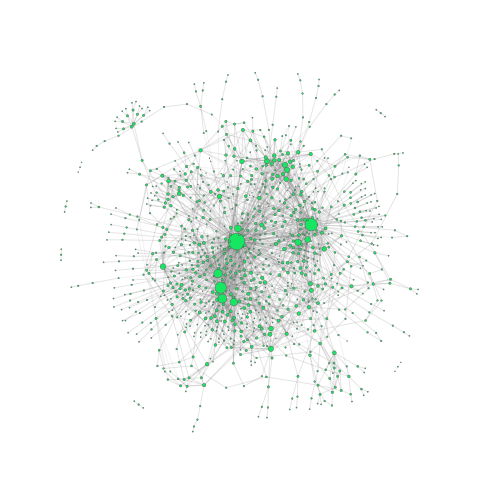

In [364]:
vis = visualize(JCVI)

## Create minimal cell enzyme network

### Step 1:
Create a list of all the enzymes within the JCVI metabolism

In [365]:
min_enzymes = set()

for name, model in models.items():
    if name == 'JCVI.sbml':
        min_enzymes.update(set(r.id for r in model.reactions))
    
#create dict of enzyme id to EC number
min_ec_dict = {}
for e in min_enzymes:
    eid = e[:-2]
    min_ec_dict[e] = get_ec_from_id(data, eid)

In [366]:
print(networks['JCVI.sbml'])

DiGraph with 1057 nodes and 3896 edges


### Step 2:
Take one enzyme, and iterate through every metabolite that is a product of that enzyme and find reactions that have said metabolite as a reactant.

In [367]:
def get_enzyme_dict(enzymes, networks):
    enzyme_dict = {}
    
    for e in enzymes:
    
        # run through each network, accumulate products of enzyme reaction
        products = set()
        matches = []

        for name, G in networks.items():
            if name != 'JCVI.sbml':
                continue
            if e in G.nodes:
                ps = G[e]
                products.update(ps)

                # print([G[p] for p in list(ps.keys())])

                # get enzymes that are pointed to by product
                for p in list(ps.keys()):
                    for n in G[p]:
                        matches.append(n)
                        
        # convert to a dictionary counting the number of each entry
        matches = dict(Counter(matches))
        
        # dont self-loop
        if e in matches:
            del matches[e]

        enzyme_dict[e] = matches
    
    return enzyme_dict

In [368]:
d =  get_enzyme_dict(min_enzymes, networks)


### Step 3:
Create the network from this dictionary by formatting it in a way where the number of edges from enzyme 𝑒1 to a product to another enzyme  𝑒2 is the weight of that edge.

In [369]:
def create_enzyme_network(enzymes, networks):
    G = nx.DiGraph()
    G.add_nodes_from(enzymes)
    d = get_enzyme_dict(enzymes, networks)
    
    # iterate through keys, then format the corresponding dictionary
    # to be an input for nx.add_weighted_edges_from
    for e in d.keys():
        neighbors = d[e]
        # print(neighbors)
        edge_list = [(e, n, w) for n, w in neighbors.items()]
        G.add_weighted_edges_from(edge_list)
    return G

In [370]:
G_min = create_enzyme_network(min_enzymes, networks)
# nx.set_node_attributes(G_enzyme, ec_dict, name="EC")
print(G_min)



DiGraph with 490 nodes and 62621 edges


In [371]:
# data = visualize(G_min)

### Step 4:
Clustering by EC number: Create a partition of enzymes based on their EC number similarity. If the first  𝑛
  numbers match, the enzymes should be in the same cluster. We will create clusters for  𝑛=1,2,3
 , giving 3 different clusterings with higher separation of enzymes as  𝑛
  increases.

In [372]:
def get_ns_from_EC(ec_number, n):
    if ec_number:
        ns = ec_number.split(".")[:n]
        return '.'.join(ns)
    return '0'

min_EC_ns1 = {e: get_ns_from_EC(ec, 1) for e, ec in min_ec_dict.items()}
min_EC_ns2 = {e: get_ns_from_EC(ec, 2) for e, ec in min_ec_dict.items()}
min_EC_ns3 = {e: get_ns_from_EC(ec, 3) for e, ec in min_ec_dict.items()}

In [373]:
# set nodes EC number to EC_ns1
nx.set_node_attributes(G_min, min_EC_ns1, 'EC')


### Step 5:
Draw the network to see the distribution of nodes by their EC number

In [333]:
def generate_displacement_vectors(num_communities, radius = 1):
    angles = np.linspace(0, 2 * np.pi, num_communities, endpoint = False)
    disp_vectors = {i: radius * np.array([np.cos(angle),np.sin(angle)]) for i, angle in enumerate(angles)}
    return disp_vectors
 
def get_num_communities(G):
    ecs = []
    for node, data in G.nodes(data=True):
        if data not in ecs:
            ecs.append(data)
    return len(ecs)
    

In [334]:
def community_layout(G, community_attribute, scale):
    # input: G - network to be graphed
    #        community_attribute - 'EC'
    
    # apply spring layout
    # pos is a dictionary with nodes as keys and positions as values
    pos = nx.spring_layout(G)
    
    # initialize dict to store center positions of each community
    community_centers = dict()
    
    # get number of communities
    num_communities = get_num_communities(G)
    
    # define a displacement vector for each community to further space them apart
    disp_vector = generate_displacement_vectors(num_communities, radius = 10)
    
    # calculate the center position of each commmunity
    for node, position in pos.items():
        community = G.nodes[node][community_attribute]
        if community in community_centers:
            community_centers[community] += position * disp_vector[int(community)]
        else:
            community_centers[community] = position * disp_vector[int(community)]
        
        
    # adjust node positions based on community centers
    for node, position in pos.items():
        community = G.nodes[node][community_attribute]
        
        # get distance between node and community center
        distance = np.linalg.norm(position - community_centers[community]) / scale
        
        # generate random angle
        random_angle = np.random.uniform(0, 2 * np.pi)
        
        # compute position based on community center and move to disp_vector of community
        new_pos = community_centers[community] + distance * np.random.uniform(0,4) * np.array([np.cos(random_angle), np.sin(random_angle)])
        
        pos[node] = new_pos 
        
    return pos

In [339]:
def draw_network_nodes(G):
    
    # num_communities = get_num_communities(G)
    # community_color = list(np.linspace(0, 256, num = num_communities, endpoint = False))
    
    community_color = {
        0 : 'grey',
        1 : 'orange',
        2 : 'green',
        3 : 'red',
        4 : 'blue',
        5 : 'cyan',
        6 : 'purple',
        7 : 'yellow',
    }
    
    node_colors = [community_color[int(G.nodes[node]['EC'])] for node in G.nodes]
    pos = community_layout(G, 'EC', scale = 10)
    nodes = nx.draw_networkx_nodes(G, pos, node_color = node_colors, node_size = 10)
    
    return

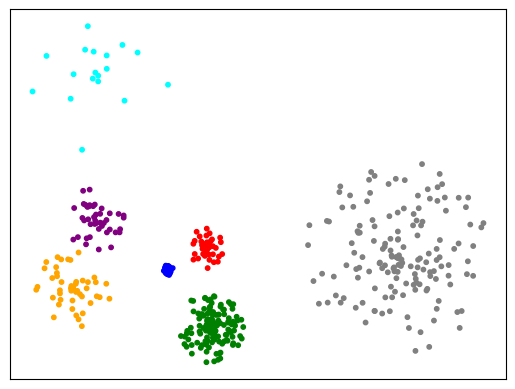

In [340]:
draw_network_nodes(G_min)

## Create Pan-Genome network of enzymes. 

*This method will connect two enzymes with a weighted directed edge ($i$ &rarr; $j$, $w$) where the weight $w$ of the edge is the number of products of enzyme $i$ that are the reactants of enzyme $j$.*

### Step 1: 
Create a list of all the enzymes. Create a dict of ec numbers for each enzyme

In [374]:
enzymes = set()

for name, model in models.items():
    if name == 'JCVI.sbml':
        continue
    enzymes.update(set(r.id for r in model.reactions))
    
# create dict of enzyme id to EC number
ec_dict = {}
for e in enzymes:
    eid = e[:-2]
    ec_dict[e] = get_ec_from_id(data, eid)

In [375]:
count = 0
total = len(ec_dict)
for e in ec_dict:
    if ec_dict[e]:
        count += 1
print(f"{count*100/total}% of the enzymes are annotated with EC numbers!")

70.89041095890411% of the enzymes are annotated with EC numbers!


### Step 2:

Take one enzyme, and iterate through every metabolite that is a product of that enzyme (in any network, not that I expect a reaction to produce something different in different networks), and find reactions that have said metabolite as a reactant.

In [377]:
def get_enzyme_dict(enzymes, networks):
    enzyme_dict = {}
    
    for e in enzymes:
    
        # run through each network, accumulate products of enzyme reaction
        products = set()
        matches = []

        for name, G in networks.items():
            if name == 'JCVI.sbml':
                continue
            if e in G.nodes:
                ps = G[e]
                products.update(ps)

                # print([G[p] for p in list(ps.keys())])

                # get enzymes that are pointed to by product
                for p in list(ps.keys()):
                    for n in G[p]:
                        matches.append(n)
                        
        # convert to a dictionary counting the number of each entry
        matches = dict(Counter(matches))
        
        # dont self-loop
        if e in matches:
            del matches[e]

        enzyme_dict[e] = matches
    
    return enzyme_dict

In [378]:
d =  get_enzyme_dict(enzymes, networks)
print(len(d))

1168


### Step 3:

Create the network from this dictionary by formatting it in a way where the number of edges from enzyme $e1$ to a product to another enzyme $e2$ is the weight of that edge.

In [379]:
def create_enzyme_network(enzymes, networks):
    G = nx.DiGraph()
    G.add_nodes_from(enzymes)
    d = get_enzyme_dict(enzymes, networks)
    
    # iterate through keys, then format the corresponding dictionary
    # to be an input for nx.add_weighted_edges_from
    for e in d.keys():
        neighbors = d[e]
        # print(neighbors)
        edge_list = [(e, n, w) for n, w in neighbors.items()]
        G.add_weighted_edges_from(edge_list)
    return G

In [380]:
G_enzyme = create_enzyme_network(enzymes, networks)
# nx.set_node_attributes(G_enzyme, ec_dict, name="EC")
print(G_enzyme)


DiGraph with 1168 nodes and 279063 edges


In [397]:
# data = visualize(G_enzyme)

### Step 4:

Clustering by EC number: Create a partition of enzymes based on their EC number similarity. If the first $n$ numbers match, the enzymes should be in the same cluster. We will create clusters for $n = 1, 2, 3$, giving 3 different clusterings with higher separation of enzymes as $n$ increases.

In [382]:
def get_ns_from_EC(ec_number, n):
    if ec_number:
        ns = ec_number.split(".")[:n]
        return '.'.join(ns)
    return '0'

EC_ns1 = {e: get_ns_from_EC(ec, 1) for e, ec in ec_dict.items()}
EC_ns2 = {e: get_ns_from_EC(ec, 2) for e, ec in ec_dict.items()}
EC_ns3 = {e: get_ns_from_EC(ec, 3) for e, ec in ec_dict.items()}

In [383]:
nx.set_node_attributes(G_enzyme, EC_ns1, 'EC')

### Step 5:

Compare the distributions of EC groupings across all of the genomes.

In [384]:
def normalized_dist(model_name, ec_ns):
    rids = [r.id for r in models[model_name].reactions]
    dist = dict(Counter([ec_ns[rid] for rid in rids]))
    val_sum = sum(dist.values())
    norm_dist = {ec: count/val_sum for ec, count in dist.items()}
    return dist, norm_dist
    

KeyError: 'rxn00926_c'

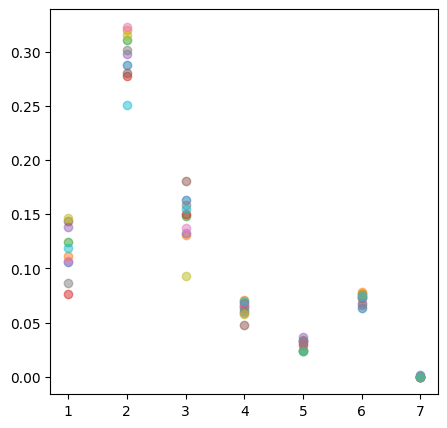

In [385]:
EC_dicts = [EC_ns1, EC_ns2, EC_ns3]

def plot_dist(n):
    ec_prefs = set()
    
    nds = {}
    
    for model_name in models.keys():
        if model_name == 'JCVI.sbml':
            continue
        
        _, nd = normalized_dist(model_name, EC_dicts[n-1])

        # print(sorted_nd)
        
        ec_prefs.update(list(nd.keys()))
        nds[model_name] = nd
    
    for model_name in models.keys():
        if model_name == 'JCVI.sbml':
            continue
        nd = nds[model_name]
        if len(nd) != len(ec_prefs):
            new_ecs = set(ec_prefs) - set(nd)
            # print(new_ecs)
            for ec in new_ecs:
                nd[ec] = 0
                
        keys = list(nd.keys())
        keys.sort()
        sorted_nd = {i: nd[i] for i in keys}
                
        k = list(sorted_nd.keys())
        v = list(sorted_nd.values())
        plt.scatter(k[1:], v[1:], label=model_name, alpha=0.5)
    return ec_prefs


def plot_JCVI(n, ec_prefs):
    _, nd = normalized_dist("JCVI.sbml", EC_dicts[n-1])
    
    if len(nd) != len(ec_prefs):
        new_ecs = set(ec_prefs) - set(nd)
        # print(new_ecs)
        for ec in new_ecs:
            nd[ec] = 0
    
    keys = list(nd.keys())
    keys.sort()
    sorted_nd = {i: nd[i] for i in keys}
    # print(sorted_nd)

    k = list(sorted_nd.keys())
    v = list(sorted_nd.values())

    plt.plot(k[1:], v[1:], '--',label='JCVI')

for n in range(1, 4):
    plt.figure(figsize=(5*n, 5))
    ecs = plot_dist(n)
    plot_JCVI(n, ecs)

    plt.title(f"Normalized distribution among {n}-clusters of EC number")
    plt.xlabel(f"EC number first {n} digits")
    plt.xticks(fontsize=10/n)
    plt.ylabel("Normalized density")
    plt.legend()
    plt.show()
# ids = [r.id for r in models[].reactions]
# print(Counter([EC_ns1[rid] for rid in ids]))
# print(Counter([EC_ns2[rid] for rid in ids]))
# print(Counter([EC_ns3[rid] for rid in ids]))

## Visualize distribution data
This only works for EC_ns1

In [386]:
def generate_displacement_vectors(num_communities, radius = 1):
    angles = np.linspace(0, 2 * np.pi, num_communities, endpoint = False)
    disp_vectors = {i: radius * np.array([np.cos(angle),np.sin(angle)]) for i, angle in enumerate(angles)}
    return disp_vectors
 
def get_num_communities(G):
    ecs = []
    for node, data in G.nodes(data=True):
        if data not in ecs:
            ecs.append(data)
    return len(ecs)
    

In [387]:
def community_layout(G, community_attribute, scale):
    # input: G - network to be graphed
    #        community_attribute - 'EC'
    
    # apply spring layout
    # pos is a dictionary with nodes as keys and positions as values
    pos = nx.spring_layout(G)
    
    # initialize dict to store center positions of each community
    community_centers = dict()
    
    # get number of communities
    num_communities = get_num_communities(G)
    
    # define a displacement vector for each community to further space them apart
    disp_vector = generate_displacement_vectors(num_communities, radius = 10)
    
    # calculate the center position of each commmunity
    for node, position in pos.items():
        community = G.nodes[node][community_attribute]
        if community in community_centers:
            community_centers[community] += position * disp_vector[int(community)]
        else:
            community_centers[community] = position * disp_vector[int(community)]
        
        
    # adjust node positions based on community centers
    for node, position in pos.items():
        community = G.nodes[node][community_attribute]
        
        # get distance between node and community center
        distance = np.linalg.norm(position - community_centers[community]) / scale
        
        # generate random angle
        random_angle = np.random.uniform(0, 2 * np.pi)
        
        # compute position based on community center and move to disp_vector of community
        new_pos = community_centers[community] + distance * np.random.uniform(0,4) * np.array([np.cos(random_angle), np.sin(random_angle)])
        
        pos[node] = new_pos 
        
    return pos

In [388]:
def draw_network_nodes(G):
    
    # num_communities = get_num_communities(G)
    # community_color = list(np.linspace(0, 256, num = num_communities, endpoint = False))
    
    community_color = {
        
        0 : 'grey',     # no EC number found
        1 : 'orange',   # Oxidoreductase
        2 : 'green',    # Transferases
        3 : 'red',      # Hydrolases
        4 : 'blue',     # Lyases
        5 : 'cyan',     # Isomerases
        6 : 'purple',   # Ligases
        7 : 'yellow',   # Translocases
        
    }
    
    node_colors = [community_color[int(G.nodes[node]['EC'])] for node in G.nodes]
    pos = community_layout(G, 'EC', scale = 10)
    nodes = nx.draw_networkx_nodes(G, pos, node_color = node_colors, node_size = 10)
    
    return

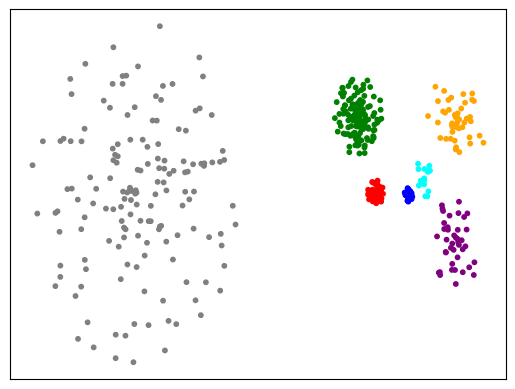

In [389]:
draw_network_nodes(G_min)

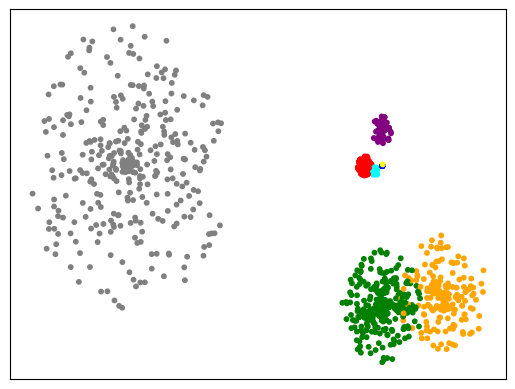

In [400]:
draw_network_nodes(G_enzyme)

In [ ]:
# check if reaction IDs are consistent throughout models
# rs = []
# for m in models:
#     rs.append(m.reactions)
    
# for r1 in rs:
#     for r2 in rs:
#         if r1 != r2:
#             for reaction in r1:
#                 rid = reaction.id
#                 reaction2 = r2.query(lambda x: x.id == rid)
#                 if reaction2:
#                     if reaction.name != reaction2[0].name:
#                         print("These names don't align!")
#                         print(rid, rid2)
#                         print(reaction.name, reaction2.name)
#                         print(r1)
#                         print(r2)

# print("Done!")
            
# Confirms that IDs are consistent throughout models, 
# i.e. if two IDs match from different models, they have the same name/formula

In [ ]:
# clustering analysis